(c) 2018 by Thomas Wiecki

People seemed to enjoy my [intuitive and visual explanation of Markov chain Monte Carlo](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) so I thought it would be fun to do another one, this time focused on copulas.

If you ask a statistician what a copula is they might say "a copula is a multivariate distribution $C(U_1, U_2, ...., U_n)$ such that marginalizing gives $U_i \sim \operatorname{\sf Uniform}(0, 1)$". OK... wait, what? I personally really dislike these math-only explanations that make many concepts appear way more difficult to understand than they actually are and copulas are a great example of that. The name alone always seemed pretty daunting to me. However, they are actually quite simple so we're going to try and demistify them a bit. At the end, we will see what role copulas played in the 2007-2008 Financial Crisis.

## Example problem case
Let's start with an example problem case. Say we measure two variables that are non-normally distributed and correlated. For example, we look at various rivers and for every river we look at the maximum level of that river over a certain time-period. In addition, we also count how many months each river caused flooding. For the probability distribution of the maximum level of the river we can look to [Extreme Value Theory](https://en.wikipedia.org/wiki/Extreme_value_theory) which tells us that maximums are [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) distributed. How many times flooding occured will be modeled according to a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) which just tells us the probability of flooding to occur as a function of how many times flooding vs non-flooding occured.

It's pretty reasonable to assume that the maximum level and number of floodings is going to be correlated. However, here we run into a problem: how should we model that probability distribution? Above we only specified the distributions for the individual variables, irrespective of the other one (i.e. the [marginals](https://en.wikipedia.org/wiki/Marginal_distribution)). In reality we are dealing with a joint distribution of both of these together.

Copulas to the rescue.

## What are copulas in English?

Copulas allow us to decompose a joint probability distribution into their marginals (which by definition have no correlation) and a function which couples (hence the name) them together and thus allows us to specify the correlation seperately. The copula is that coupling function.

Before we dive into them, we must first learn how we can transform arbitrary random variables to uniform and back. All we will need is the excellent `scipy.stats` module and `seaborn` for plotting.

In [1]:
%matplotlib inline

import seaborn as sns
from scipy import stats

## Transforming random variables

Let's start by sampling uniformly distributed values between 0 and 1:

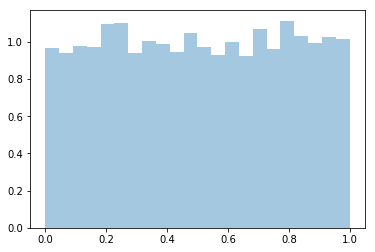

In [2]:
x = stats.uniform(0, 1).rvs(10000)
sns.distplot(x, kde=False, norm_hist=True);

Next, we want to transform these samples so that instead of uniform they are now normally distributed. The transform that does this is the inverse of the [cumulative density function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the normal distribution (which we can get in `scipy.stats` with `ppf`):

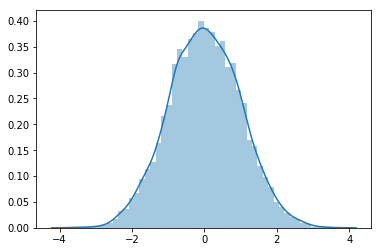

In [3]:
norm = stats.distributions.norm()
x_trans = norm.ppf(x)
sns.distplot(x_trans);

If we plot both of them together we can get an intuition for what the inverse CDF looks like and how it works:

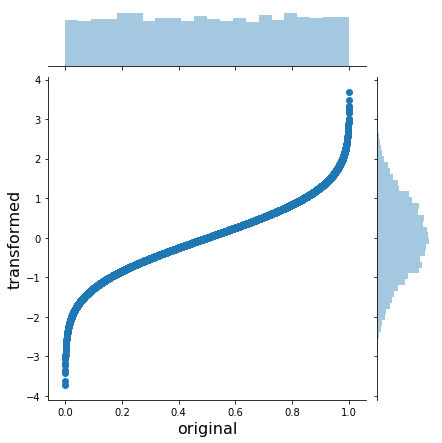

In [4]:
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

As you can see, the inverse CDF stretches the outer regions of the uniform to yield a normal.

We can do this for arbitrary (univariate) probability distributions, like the Beta:

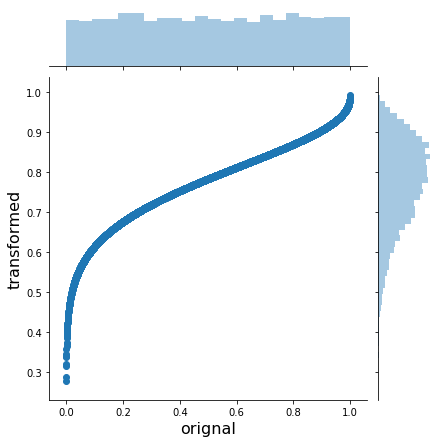

In [5]:
beta = stats.distributions.beta(a=10, b=3)
x_trans = beta.ppf(x)
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('orignal', 'transformed', fontsize=16);

Or a Gumbel:

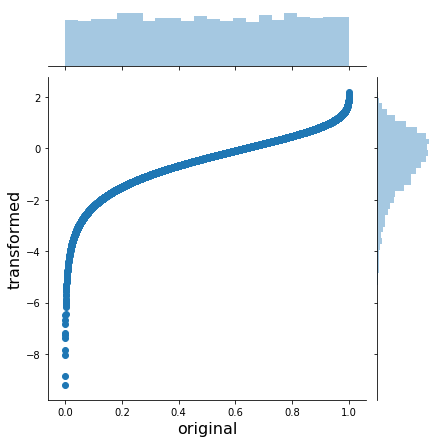

In [6]:
gumbel = stats.distributions.gumbel_l()
x_trans = gumbel.ppf(x)
h = sns.jointplot(x, x_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

In order to do the opposite transformation from an arbitrary distribution to the uniform(0, 1) we just apply the inverse of the inverse CDF -- the CDF:

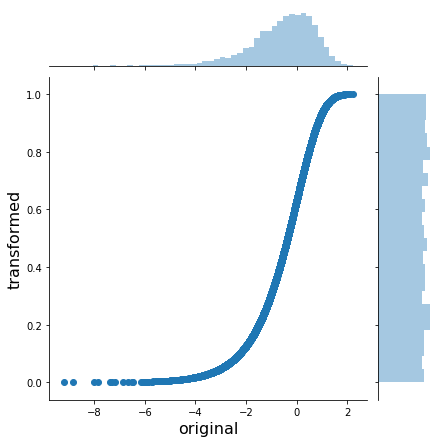

In [7]:
x_trans_trans = gumbel.cdf(x_trans)
h = sns.jointplot(x_trans, x_trans_trans, stat_func=None)
h.set_axis_labels('original', 'transformed', fontsize=16);

OK, so we know how to transform from any distribution to uniform and back. In math-speak this is called the [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform).

## Adding correlation with Gaussian copulas

How does this help us with our problem of creating a custom joint probability distribution? We're actually almost done already. We know how to convert anything uniformly distributed to an arbitrary probability distribution. So that means we need to generate uniformly distributed data with the correlations we want. How do we do that? We simulate from a multivariate Gaussian with the specific correlation structure, transform so that the marginals are uniform, and then transform the uniform marginals to whatever we like.

Create samples from a correlated multivariate normal:

In [8]:
mvnorm = stats.multivariate_normal(mean=[0, 0], cov=[[1., 0.5], 
                                                     [0.5, 1.]])
# Generate random samples from multivariate normal with correlation .5
x = mvnorm.rvs(100000)

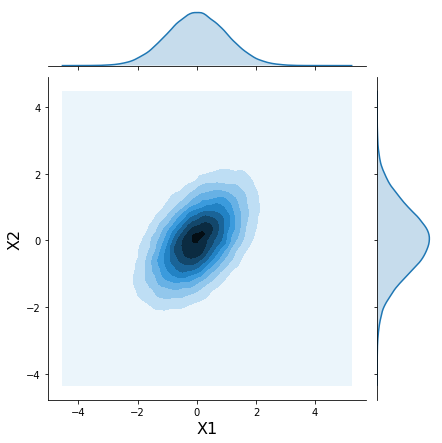

In [9]:
h = sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

Now use what we learned above to "uniformify" the marignals:

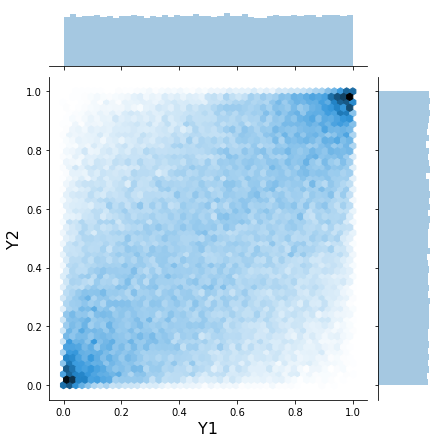

In [10]:
norm = stats.norm()
x_unif = norm.cdf(x)
h = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);

This joint plot above is usually how copulas are visualized.

Now we just transform the marginals again to what we want (Gumbel and Beta):

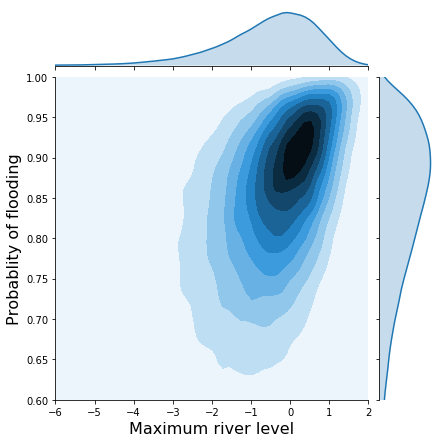

In [11]:
m1 = stats.gumbel_l()
m2 = stats.beta(a=10, b=2)

x1_trans = m1.ppf(x_unif[:, 0])
x2_trans = m2.ppf(x_unif[:, 1])

h = sns.jointplot(x1_trans, x2_trans, kind='kde', xlim=(-6, 2), ylim=(.6, 1.0), stat_func=None);
h.set_axis_labels('Maximum river level', 'Probablity of flooding', fontsize=16);

Contrast that with the joint distribution without correlations:

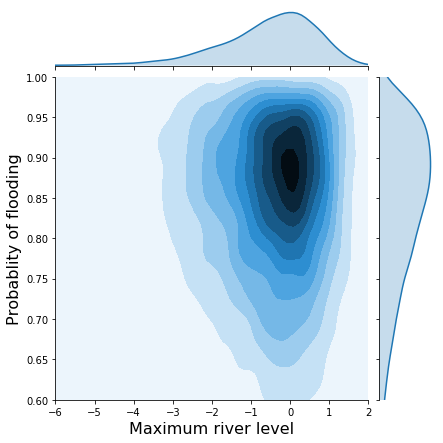

In [12]:
x1 = m1.rvs(10000)
x2 = m2.rvs(10000)

h = sns.jointplot(x1, x2, kind='kde', xlim=(-6, 2), ylim=(.6, 1.0), stat_func=None);
h.set_axis_labels('Maximum river level', 'Probablity of flooding',  fontsize=16);

So there we go, by using the uniform distribution as our lingua franca we can easily induce correlations and flexibly construct complex probability distributions. This all directly extends to higher dimensional distributions as well.

## More complex correlation structures and the Financial Crisis

Above we used a multivariate normal which gave rise to the Gaussian copula. However, we can use other, more complex copulas as well. For example, we might want to assume the correlation is non-symmetric which is useful in quant finance where correlations become very strong during market crashes and returns are very negative. 

In fact, Gaussian copulas are said to have played a key role in the 2007-2008 Financial Crisis as tail-correlations were severely underestimated. If you've seen [The Big Short](https://www.imdb.com/title/tt1596363/), the default rates of individual mortgages (among other things) inside CDOs (see [this scene](https://www.youtube.com/watch?v=A25EUhZGBws) from the movie as a refresher) are correlated -- if one mortgage fails, the likelihood of another failing is increased. In the early 2000s, the banks only knew how to model the marginals of the default rates. This infamous [paper by Li](http://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/9c8e3fd4d8874d60c1257052003eced6/34e84cb615c8b4eac12575fe006a9759/$FILE/li.defaultcorrelation.pdf) then suggested to use copulas to model the correlations between those marginals. Rating agencies relied on this model heavily, severly underestimating risk and giving false ratings. The rest, as they say, is history. 

Read [this paper](https://www.maths.ox.ac.uk/system/files/attachments/1000332.pdf) for an excellent description of Gaussian copulas and the Financial Crisis which argues that different copula choices would not have made a difference but instead the assumed correlation was way too low.

## Getting back to the math

Maybe now the statement "a copula is a multivariate distribution $C(U_1, U_2, ...., U_n)$ such that marginalizing gives $U_i \sim \operatorname{\sf Uniform}(0, 1)$" makes a bit more sense. It really is just a function with that property of uniform marginals. It's really only useful though combined with another transform to get the marginals we want.

We can also better understand the mathematical description of the Gaussian copula (taken from Wikipedia):

> For a given $R\in[-1, 1]^{d\times d}$, the Gaussian copula with parameter matrix <math>R</math> can be written as
$C_R^{\text{Gauss}}(u) = \Phi_R\left(\Phi^{-1}(u_1),\dots, \Phi^{-1}(u_d) \right)$
where $\Phi^{-1}$ is the inverse cumulative distribution function of a standard normal and $\Phi_R$ is the joint cumulative distribution function of a multivariate normal distribution with mean vector zero and covariance matrix equal to the correlation matrix <math>R</math>.

Just note that in the code above we went the opposite way to create samples from that distribution. The Gaussian copula as expressed here takes uniform(0, 1) inputs, transforms them to be Gaussian, then applies the correlation and transforms them back to uniform.

## Support me on Patreon

Finally, if you enjoyed this blog post, consider [supporting me on Patreon](https://www.patreon.com/twiecki) which allows me to devote more time to writing new blog posts.

## More reading

This post is intentionally light on math. You can find that elsewhere and will hopefully be less confused as you have a strong mental model to integrate things into. I found these links helpful:

* [Tensorflow Probability Bijection tutorial using copulas](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Copula.ipynb)
* [Wikipedia article on copulas](https://en.wikipedia.org/wiki/Copula_(probability_theory)
* [Matlab tutorial](https://de.mathworks.com/help/stats/examples/simulating-dependent-random-variables-using-copulas.html)
* [The underlying NB of this post](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/copulas.ipynb)

We also haven't addressed how we would actually fit a copula model. I leave that, as well as the [PyMC3](http://docs.pymc.io/) implementation, as an exercise to the motivated reader ;).

## Acknowledgements
Thanks to [Adrian Seyboldt](https://twitter.com/aseyboldt), [Jon Sedar](https://twitter.com/jonsedar), [Colin Carroll](https://twitter.com/colindcarroll), and [Osvaldo Martin](https://twitter.com/aloctavodia) for comments on an earlier draft. Special thanks to [Jonathan Ng](https://twitter.com/_jonathanng_) for being a Patreon supporter.